<a href="https://colab.research.google.com/github/blueeagle100/think_autonomous/blob/main/kalman_filters_course/track_bicycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project for Think Autonoumous Kalman Filters Course

### First download required packages and get folder structure from Google Drive

In [ ]:
!pip install yolo5 # version 0.0.1 used at the moment of recording

In [ ]:
!pip install Pillow==7.1.2

In [2]:
# get model weights

!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install
!ls

Cloning into 'yolov5'...
remote: Enumerating objects: 12447, done.
remote: Total 12447 (delta 0), reused 0 (delta 0), pack-reused 12447
Receiving objects: 100% (12447/12447), 12.15 MiB | 28.48 MiB/s, done.
Resolving deltas: 100% (8591/8591), done.
/content/yolov5
CONTRIBUTING.md  export.py   models	       setup.cfg       utils
data		 hubconf.py  README.md	       train.py        val.py
detect.py	 LICENSE     requirements.txt  tutorial.ipynb


In [3]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

os.chdir("/content/drive/My Drive/think_autonomous/kalman_filters_course")
!ls

Mounted at /content/drive
'Designing a Kalman Filter.ipynb'	    __pycache__
'Designing a Kalman Filter Starter.ipynb'   README.md
 Final_Project.ipynb			    track.mp4
 Final_Project_Starter.ipynb		    yolo_for_tracking_2.py
 images					    yolov5
 Probabilities.ipynb			    yolov5s.pt


In [4]:
import yolov5

# load model
model = yolov5.load('yolov5/models/yolov5s.pt')

In [5]:
model.conf = 0.35 # 0.5
model.iou = 0.4

In [7]:
import time
import yaml
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

#### Get MSCOCO classes

In [8]:
fp = r'yolov5/data/coco128.yaml'

with open(fp, "r") as stream:
    try:
        coco_info = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# get classes dictionary
classes = {i : name for i, name in enumerate(coco_info['names'])}

#### Helper functions

In [9]:
def id_to_color(idx):
    """
    Random function to convert an id to a color
    (keep numbers below 255)
    """
    blue = idx*5 % 256
    green = idx*12 %256
    red = idx*23 %256
    return (red, green, blue)

def draw_boxes_v5(image_in, boxes, categories, mot_mode=False):
    image = image_in.copy()
    h, w, _ = image.shape
    for i, box in enumerate(boxes):
        label = classes[int(categories[i])]
        color = id_to_color(i*10) if mot_mode==True else (255,0,60)
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, thickness=3)
        cv2.putText(image, str(label), (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=3)
    return image

def inference(img, draw_boxes=True):
    results = model(img)
    predictions = results.pred[0]
    boxes = predictions[:, :4].tolist()
    boxes_int = [[int(v) for v in box] for box in boxes]
    scores = predictions[:,4].tolist()
    categories = predictions[:,5].tolist()
    categories_int = [int(c) for c in categories]
    
    if draw_boxes:
      img_out = draw_boxes_v5(img, boxes_int, categories_int, mot_mode=False)
    else:
      img_out = img.copy()

    # change everything to arrays
    boxes_int = np.array(boxes_int)
    categories_int = np.array(categories_int)
    scores = np.array(scores)
    return img_out, boxes_int, categories_int, scores

## Get Bicycle bounding boxes and X-Y location in each frame

In [61]:
# trim video if trimmed video not in direcotry
from moviepy.editor import VideoFileClip
# from google.colab.patches import cv2_imshow

video_path = r'images/VIRAT_S_010204_09_001285_001336.mp4'
clip = VideoFileClip(video_path).subclip(15,25)

clip.write_videofile(r'images/VIRAT_S_010204_09_001285_001336_BICYCLE_TRIM.mp4')

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2023424/45929032 bytes (4.4%)4866048/45929032 bytes (10.6%)7421952/45929032 bytes (16.2%)10395648/45929032 bytes (22.6%)13451264/45929032 bytes (29.3%)16474112/45929032 bytes (35.9%)19365888/45929032 bytes (42.2%)22069248/45929032 bytes (48.1%)24895488/45929032 bytes (54.2%)27721728/45929032 bytes (60.4%)30703616/45929032 bytes (66.9%)33546240/45929032 bytes (73.0%)

100%|██████████| 240/240 [00:08<00:00, 27.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: images/VIRAT_S_010204_09_001285_001336_BICYCLE_TRIM.mp4 



In [20]:
video_path = r'images/VIRAT_S_010204_09_001285_001336_BICYCLE_TRIM.mp4'

# store some outputs in lists
output_frames = []
BICYCLE_MEASUREMENTS = []
TIMESTAMPS = []

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    # prepare frame for model input
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_out, boxes_int, categories_int, scores = inference(frame, draw_boxes=False)
    
    # update time stamps
    TIMESTAMPS.append(time.time())

    # if a Bicycle was detected draw boxes
    if 1 in categories_int:
        bicycle_locs = categories_int == 1
        boxes = boxes_int[bicycle_locs]
        cats = categories_int[bicycle_locs]

        # draw bicycle bounding box
        boxed_image = draw_boxes_v5(img_out, boxes, cats, mot_mode=True)
        output_frames.append(boxed_image)
        
        # update bicycle location
        x1, y1 = boxes[0][0], boxes[0][1]
        x2, y2 = boxes[0][2], boxes[0][3]
        x = (x1 + x2) / 2
        y = (y1 + y2) / 2
        BICYCLE_MEASUREMENTS.append([x, y])

    # else add not detected string
    else:
        BICYCLE_MEASUREMENTS.append("Not detected")
        output_frames.append(img_out)

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...


In [21]:
BICYCLE_MEASUREMENTS

['Not detected',
 [274.5, 321.5],
 [278.0, 322.5],
 [291.0, 318.0],
 [292.5, 319.5],
 [292.5, 321.5],
 [294.0, 322.0],
 [301.5, 323.0],
 [304.0, 324.5],
 [306.0, 325.0],
 [308.0, 324.5],
 [311.5, 322.5],
 [315.5, 323.0],
 [322.5, 321.0],
 [325.5, 325.0],
 [329.5, 325.5],
 [335.5, 325.5],
 [337.5, 326.5],
 [341.0, 324.5],
 [347.5, 327.0],
 [350.0, 329.5],
 [351.0, 329.5],
 [355.5, 326.0],
 [359.5, 324.5],
 [363.0, 323.0],
 [365.5, 323.0],
 [367.0, 323.5],
 [368.0, 324.0],
 [372.5, 323.5],
 [375.0, 324.5],
 [379.0, 324.5],
 [380.0, 323.0],
 [385.5, 328.5],
 [386.0, 328.0],
 [387.5, 326.5],
 [388.5, 325.5],
 [392.5, 324.0],
 [394.0, 324.0],
 [395.5, 324.0],
 [396.5, 325.5],
 [401.5, 329.5],
 [402.5, 331.0],
 [403.0, 330.0],
 [406.5, 329.5],
 [409.0, 332.0],
 [410.5, 331.5],
 [412.0, 332.5],
 [414.5, 337.0],
 [418.5, 336.5],
 [419.5, 336.0],
 [421.5, 335.0],
 [423.5, 335.5],
 'Not detected',
 'Not detected',
 'Not detected',
 'Not detected',
 'Not detected',
 'Not detected',
 'Not detected

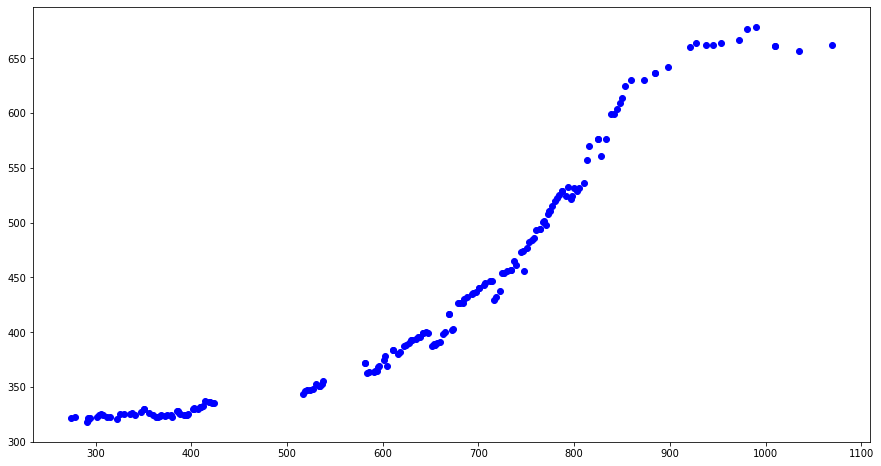

In [22]:
# just for fun, plot the bicycle path!

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
for xy in BICYCLE_MEASUREMENTS:
    if not isinstance(xy, str):
        ax.scatter(xy[0], xy[1], marker='o', color='b')

In [23]:
from tqdm import tqdm

result_video = []

for img in tqdm(output_frames):
    result_video.append(img)

100%|██████████| 240/240 [00:00<00:00, 794501.15it/s]


In [24]:
out = cv2.VideoWriter('images/BICYCLE_DETECT_0.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (img.shape[1],img.shape[0]))

for img in result_video:
  out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
out.release()

## Get Kalman Filter to track Bicycle

In [25]:
!pip install filterpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 21.7 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=c14dbcce0c213a6ac5779dd796fd931047d984956455b327b01bd8ba0baf61c0
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
Successfully built filterpy


In [ ]:
### Fo

### Kalman Filter approach

For the system model we will try 2 different kinematic models and compare how they perform. 
  - Constant Acceleration
  - Constant Velocity

  We assume that the X pos/vel/acc  and Y pos/vel/acc are the same and indepent of each other (see https://dsp.stackexchange.com/questions/11205/kalman-filter-covariance). This modeling assumption will cause the error ellipses to be circular.

Since we are tracking an object on a screen, there isn't any apparent reason to assume that the X and Y component unceratianties (modeled errors) will be significantly different. 

In [521]:
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
import numpy as np
import matplotlib.pyplot as plt


def constantAcceleration_KF(R_std, Q_std, dt, w, h):
    ''' creates and instantiates a filterpy 2D Kalman Filter object
        with a 2D constant acceleration model
        Inputs:
            R_Std (float) - measurement uncertainty
            Q_std (float) - Proccess noise covariance
            dt (float) - System Time Step
            w (int) - Frame Width
            h (int) - Frame Height
        Outputs:
            kf (filterpy object) 2D Kalman Filter object
    '''
    kf = KalmanFilter(dim_x=6, dim_z=2)
    kf.x = np.array([w//2, 0.1, 0, h//2, 0.1, 0]) # initial state (center of frame)
    kf.P = np.eye(6)*np.max([w//2, h//2])
    q = Q_discrete_white_noise(dim=3, dt=dt, var=Q_std**2)
    kf.Q = block_diag(q, q) # Process noise covariance
    kf.R = np.eye(2) * R_std**2 # measurement uncertainty/noise
    kf.H = np.array([[1, 0, 0, 0, 0, 0],  # measurement function
                     [0, 0, 0, 1, 0, 0]])
    kf.F = np.array([[1, dt, 0.5*dt*dt, 0, 0,  0],     # state transition matrix
                     [0, 1,  dt,        0, 0,  0],
                     [0, 0,  1,         0, 0,  0],
                     [0, 0,  0,         1, dt, 0.5*dt*dt],
                     [0, 0,  0,         0, 1,  dt],
                     [0, 0,  0,         0, 0,  1]])

    return kf

In [522]:
def constantVelocity_KF(R_std, Q_std, dt, w, h):
    ''' creates and instantiates a filterpy 2D Kalman Filter object
        with a 2D constant acceleration model
        Inputs:
            R_Std (float) - measurement uncertainty
            Q_std (float) - Proccess noise covariance
            dt (float) - System Time Step
            w (int) - Frame Width
            h (int) - Frame Height
        Outputs:
            kf (filterpy object) 2D Kalman Filter object
    '''
    kf = KalmanFilter(dim_x=4, dim_z=2)
    kf.x = np.array([w//2, 0.1, h//2, 0.1]) # initial state (center of frame)
    kf.P = np.eye(4)*np.max([w//2, h//2])
    q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
    kf.Q = block_diag(q, q) # Process noise covariance
    kf.R = np.eye(2) * R_std**2 # measurement uncertainty/noise
    kf.H = np.array([[1, 0, 0, 0],  # measurement function
                     [0, 0, 1, 0]])
    
    kf.F = np.array([[1, dt, 0, 0],     # state transition matrix
                     [0, 1,  0, 0],
                     [0, 0,  1, dt],
                     [0, 0,  0, 1]])

    return kf

In [598]:
# use with corrected Q init
R_std_a = 7.5 # measurement uncertainty
Q_std_a = 0.65 #  process noise
dt_a = np.mean(np.diff(TIMESTAMPS)) + 0.2 # time delta

# use with constant velocity model
R_std_v = 7.5 # measurement uncertainty
Q_std_v = 0.85 #  process noise
dt_v = np.mean(np.diff(TIMESTAMPS)) # time delta

# frame width and height
w, h = 1280, 720

# initialize Kalman Filters
const_accel_kf = constantAcceleration_KF(R_std_a, Q_std_a, dt_a, w, h)
const_vel_kf = constantVelocity_KF(R_std_v, Q_std_v, dt_v, w, h)

# store values in lists
accel_updates = [] # estimates from measurement updates
accel_preds = [] # estimates from predictions

vel_updates = [] # estimates from measurement updates
vel_preds = [] # estimates from predictions


# iterate through the measurements
for xy in BICYCLE_MEASUREMENTS:
    # Predict next state
    const_accel_kf.predict()
    const_vel_kf.predict()

    # update state with new measurement
    if not isinstance(xy, str):
        const_accel_kf.update(xy)
        accel_updates.append(const_accel_kf.x)

        const_vel_kf.update(xy)
        vel_updates.append(const_vel_kf.x)

    # append predictions
    accel_preds.append(const_accel_kf.x)
    vel_preds.append(const_vel_kf.x)


In [608]:
const_accel_kf.P[0, 0]

array([[     813.78,      284.17,      51.676,           0,           0,           0],
       [     284.17,      108.27,      22.483,           0,           0,           0],
       [     51.676,      22.483,      6.1153,           0,           0,           0],
       [          0,           0,           0,      813.78,      284.17,      51.676],
       [          0,           0,           0,      284.17,      108.27,      22.483],
       [          0,           0,           0,      51.676,      22.483,      6.1153]])

In [610]:
const_accel_kf.P[3, 3]

813.7799419155755

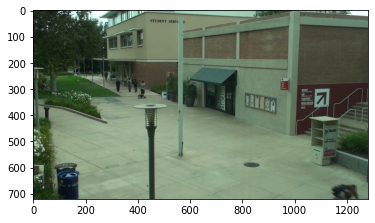

In [611]:
plt.imshow(img)

In [ ]:
cv2.ellipse(img, (x,y), (px,py)), 0, 0, 360, color, 5)

In [599]:
updates_a_arr = np.array(accel_updates)
preds_a_arr = np.array(accel_preds)

updates_v_arr = np.array(vel_updates)
preds_v_arr = np.array(vel_preds)

# constant acceleration model
pos_updates_a = updates_a_arr[:, [0, 3]]
pos_preds_a = preds_a_arr[:, [0, 3]]

# constant velocity model
pos_updates_v = updates_v_arr[:, [0, 2]]
pos_preds_v = preds_v_arr[:, [0, 2]]

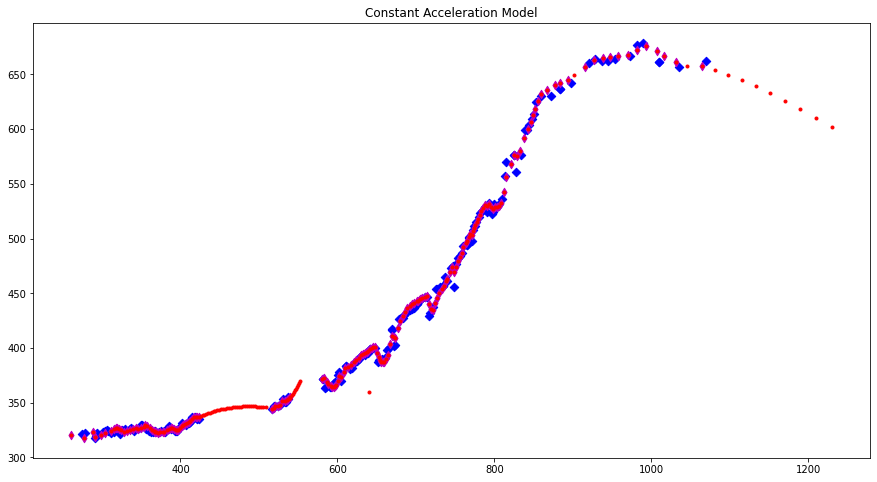

In [600]:
fig = plt.figure(figsize=(15, 8))
for xy in BICYCLE_MEASUREMENTS:
  if not isinstance(xy, str):
    plt.scatter(xy[0], xy[1], marker='D', color='b')

plt.scatter(pos_updates_a[:, 0], pos_updates_a[:, 1], marker='d', color='m')
plt.scatter(pos_preds_a[:, 0], pos_preds_a[:, 1], marker='.', color='r')

plt.title('Constant Acceleration Model');

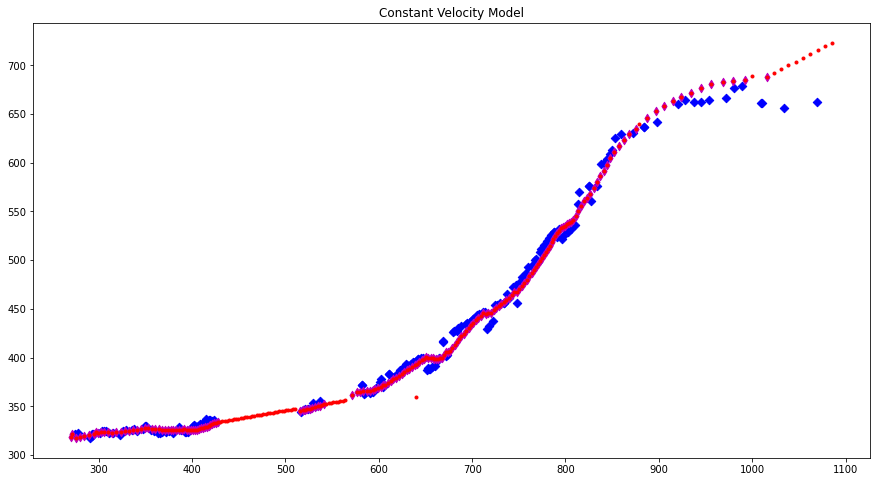

In [601]:
fig = plt.figure(figsize=(15, 8))
for xy in BICYCLE_MEASUREMENTS:
  if not isinstance(xy, str):
    plt.scatter(xy[0], xy[1], marker='D', color='b')

plt.scatter(pos_updates_v[:, 0], pos_updates_v[:, 1], marker='d', color='m')
plt.scatter(pos_preds_v[:, 0], pos_preds_v[:, 1], marker='.', color='r')

plt.title('Constant Velocity Model');

We can see that the Constant Acceleration trys to better fit the measurements of the bicycle, and even seems to fit the noise. It does well to predict the postion for the first measurement gap, but it doesn't quite do the job on the second measurement gap. NOTE: This model was hard to tune, and likely wouldn't perform well in other environements or datasetas

The constant velocity model fits the data well , and doesn't fit the noisy measurements like the constant acceleration model does. It seems to do a good job of fitting the measurement gaps. However towrads the end of the track the model trusts it's own measurements too much and doesn't quite extrapolate it like the constant acceleration model. Some more tuning can likely help with this. NOTE: Compared to the constant acceleration model, this model was much easier to tune.


Future Work would be to consider and Extended Kalman Filter to model the motion.

In [612]:
# use with corrected Q init
R_std_a = 7.5 # measurement uncertainty
Q_std_a = 0.65 #  process noise
dt_a = np.mean(np.diff(TIMESTAMPS)) + 0.2 # time delta

# use with constant velocity model
R_std_v = 7.5 # measurement uncertainty
Q_std_v = 0.85 #  process noise
dt_v = np.mean(np.diff(TIMESTAMPS)) # time delta


# frame width and height
w, h = 1280, 720

# initialize Kalman Filters
const_accel_kf = constantAcceleration_KF(R_std_a, Q_std_a, dt_a, w, h)
const_vel_kf = constantVelocity_KF(R_std_v, Q_std_v, dt_v, w, h)

def main_pipeline(image):
    # Predict next state
    const_accel_kf.predict()
    const_vel_kf.predict()

    # prepare frame for model input
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_out, boxes_int, categories_int, scores = inference(image, draw_boxes=False)

    # if a Bicycle was detected draw boxes
    if 1 in categories_int:
        bicycle_locs = categories_int == 1
        boxes = boxes_int[bicycle_locs]
        cats = categories_int[bicycle_locs]

        # draw bicycle bounding box
        img_out = draw_boxes_v5(img_out, boxes, cats, mot_mode=True)
        
        # update bicycle location
        x1, y1 = boxes[0][0], boxes[0][1]
        x2, y2 = boxes[0][2], boxes[0][3]
        x = (x1 + x2) / 2
        y = (y1 + y2) / 2

        # update state based on new measurement
        const_accel_kf.update([x, y])
        const_vel_kf.update([x, y])

    # draw new estimate point on image
    x_est_a, y_est_a = int(np.round(const_accel_kf.x[0])), int(np.round(const_accel_kf.x[3])) # Q init
    x_est_v, y_est_v = int(np.round(const_vel_kf.x[0])), int(np.round(const_vel_kf.x[2])) # const vel

    cv2.circle(img_out, (x_est_a, y_est_a), 5, (0, 255, 0), -1)
    cv2.circle(img_out, (x_est_v, y_est_v), 5, (255, 0, 0), -1)

    # draw uncertainty ellipses
    px_a, py_a = int(np.round(const_accel_kf.P[0,0])), int(np.round(const_accel_kf.P[3,3])) # Q init
    px_v, py_v = int(np.round(const_vel_kf.P[0,0])), int(np.round(const_vel_kf.P[2,2])) # const vel

    cv2.ellipse(img_out, (x_est_a, y_est_a), (px_a, py_a), 0, 0, 360, (0, 255, 0), 5)
    cv2.ellipse(img_out, (x_est_v, y_est_v), (px_v, py_v), 0, 0, 360, (255, 0, 0), 5)

    return img_out



In [613]:
from moviepy.editor import VideoFileClip

video_path = r'images/VIRAT_S_010204_09_001285_001336_BICYCLE_TRIM.mp4'
clip = VideoFileClip(video_path)
tracked_clip = clip.fl_image(main_pipeline)
%time tracked_clip.write_videofile("/content/drive/My Drive/think_autonomous/kalman_filters_course/images/track_with_ellipses.mp4",audio=False)

[MoviePy] >>>> Building video /content/drive/My Drive/think_autonomous/kalman_filters_course/images/track_with_ellipses.mp4
[MoviePy] Writing video /content/drive/My Drive/think_autonomous/kalman_filters_course/images/track_with_ellipses.mp4


100%|█████████▉| 240/241 [01:10<00:00,  3.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/My Drive/think_autonomous/kalman_filters_course/images/track_with_ellipses.mp4 

CPU times: user 1min 5s, sys: 16.5 s, total: 1min 21s
Wall time: 1min 11s
